In [62]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# import visualization
import matplotlib.pyplot as plt

# import machine learning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestRegressor

In [63]:
# load data
fires = pd.read_csv('../input/forest-fires-data-set/forestfires.csv')
fires.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


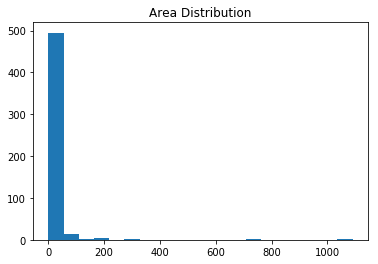

In [64]:
plt.hist(fires.area, bins=20)
plt.title('Area Distribution')
plt.show()

Long-tailed distribution with small number of samples for high area values.

In [65]:
# simple regression model
fires = fires.drop(columns=['X', 'Y'])

months_to_remove = ['nov','jan','may']
fires = fires.drop(fires[fires.month.isin(months_to_remove)].index ,axis=0)

fires['temp_bins'] = pd.cut(fires.temp, bins=[0, 15, 20, 25, 40], include_lowest=True, 
                                 labels=['0-15', '15-20', '20-25', '>25'])

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(fires.values, fires.temp_bins.values):
    st_train_set = fires.iloc[train_index]
    st_test_set = fires.iloc[test_index]

In [66]:
X_train = st_train_set.drop(columns=['area', 'temp_bins'])
X_train = pd.get_dummies(X_train)

y_train = st_train_set[['area']]

X_test = st_test_set.drop(columns=['area', 'temp_bins'])
X_test = pd.get_dummies(X_test)
y_test = st_test_set[['area']]

model = RandomForestRegressor(max_depth=2, min_samples_split=2, min_samples_leaf=1, random_state=0, n_estimators=100)
model.fit(X_train, y_train.values.ravel())

y_pred = model.predict(X_test)

# print out the prediction scores
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))
print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))
print('R-squared: {}'.format(explained_variance_score(y_test, y_pred)))

RMSE: 80.90378771420649
MAE: 22.520703240785696
R-squared: 0.005531120754761476


Text(0.5, 1.0, 'Predicted vs True values')

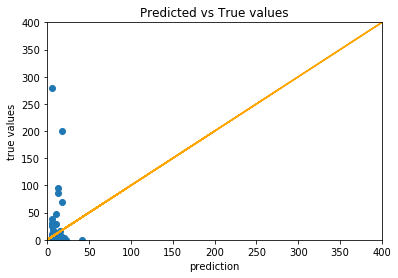

In [67]:
plt.scatter(y_pred, y_test)
plt.plot(y_test, y_test, c = 'orange')
plt.xlabel('prediction')
plt.ylabel('true values')
plt.xlim(0,400)
plt.ylim(0,400)
plt.title('Predicted vs True values')

We see that the model performs very bad. Ideally the dots should be near the line.

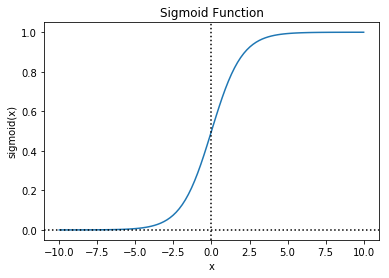

In [68]:
# define sigmoid function
# https://en.wikipedia.org/wiki/Sigmoid_function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# plot sigmoid function
plt.plot(np.linspace(-10, 10, 100), sigmoid(np.linspace(-10, 10, 100)))
plt.title('Sigmoid Function')
plt.xlabel('x')
plt.axhline(y=0, c='black', linestyle=':')
plt.axvline(x=0, c='black', linestyle=':')
plt.ylabel('sigmoid(x)')
plt.show()

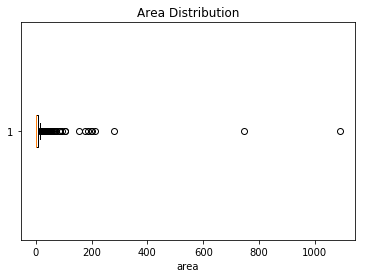

In [69]:
# plot the boxplot of area distribution
plt.boxplot(fires.area, vert=False)
plt.title('Area Distribution')
plt.xlabel('area')
plt.show()

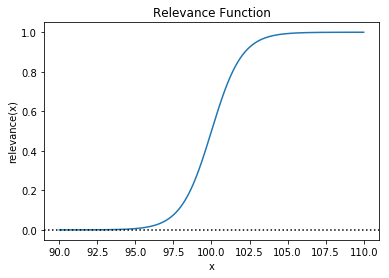

In [70]:
# implement relevance function
# see paper: https://www.researchgate.net/publication/220699419_Utility-Based_Regression
def relevance(x):
    x = np.array(x)
    return sigmoid(x - 100)

# plot relevance function
plt.plot(np.linspace(90, 110, 1000), relevance(np.linspace(90, 110, 1000)))
plt.title('Relevance Function')
plt.xlabel('x')
plt.axhline(y=0, c='black', linestyle=':')
#plt.axvline(x=0, c='black', linestyle=':')
plt.ylabel('relevance(x)')
plt.show()

In [71]:
# implement SMOTER
# see paper: https://core.ac.uk/download/pdf/29202178.pdf

def get_synth_cases(D, target, o=200, k=3, categorical_col = []):
    '''
    Function to generate the new cases.
    INPUT:
        D - pd.DataFrame with the initial data
        target - string name of the target column in the dataset
        o - oversampling rate
        k - number of nearest neighbors to use for the generation
        categorical_col - list of categorical column names
    OUTPUT:
        new_cases - pd.DataFrame containing new generated cases
    '''
    new_cases = pd.DataFrame(columns = D.columns) # initialize the list of new cases 
    ng = o // 100 # the number of new cases to generate
    for index, case in D.iterrows():
        # find k nearest neighbors of the case
        knn = KNeighborsRegressor(n_neighbors = k+1) # k+1 because the case is the nearest neighbor to itself
        knn.fit(D.drop(columns = [target]).values, D[[target]])
        neighbors = knn.kneighbors(case.drop(labels = [target]).values.reshape(1, -1), return_distance=False).reshape(-1)
        neighbors = np.delete(neighbors, np.where(neighbors == index))
        for i in range(0, ng):
            # randomly choose one of the neighbors
            x = D.iloc[neighbors[np.random.randint(k)]]
            attr = {}          
            for a in D.columns:
                # skip target column
                if a == target:
                    continue;
                if a in categorical_col:
                    # if categorical then choose randomly one of values
                    if np.random.randint(2) == 0:
                        attr[a] = case[a]
                    else:
                        attr[a] = x[a]
                else:
                    # if continious column
                    diff = case[a] - x[a]
                    attr[a] = case[a] + np.random.randint(2) * diff
            # decide the target column
            new = np.array(list(attr.values()))
            d1 = cosine_similarity(new.reshape(1, -1), case.drop(labels = [target]).values.reshape(1, -1))[0][0]
            d2 = cosine_similarity(new.reshape(1, -1), x.drop(labels = [target]).values.reshape(1, -1))[0][0]
            attr[target] = (d2 * case[target] + d1 * x[target]) / (d1 + d2)
            
            # append the result
            new_cases = new_cases.append(attr,ignore_index = True)
                    
    return new_cases

def SmoteR(D, target, th = 0.999, o = 200, u = 100, k = 3, categorical_col = []):
    '''
    The implementation of SmoteR algorithm:
    https://core.ac.uk/download/pdf/29202178.pdf
    INPUT:
        D - pd.DataFrame - the initial dataset
        target - the name of the target column in the dataset
        th - relevance threshold
        o - oversampling rate
        u - undersampling rate
        k - the number of nearest neighbors
    OUTPUT:
        new_D - the resulting new dataset
    '''
    # median of the target variable
    y_bar = D[target].median()
    
    # find rare cases where target less than median
    rareL = D[(relevance(D[target]) > th) & (D[target] > y_bar)]  
    # generate rare cases for rareL
    new_casesL = get_synth_cases(rareL, target, o, k , categorical_col)
    
    # find rare cases where target greater than median
    rareH = D[(relevance(D[target]) > th) & (D[target] < y_bar)]
    # generate rare cases for rareH
    new_casesH = get_synth_cases(rareH, target, o, k , categorical_col)
    
    new_cases = pd.concat([new_casesL, new_casesH], axis=0)
    
    # undersample norm cases
    norm_cases = D[relevance(D[target]) <= th]
    # get the number of norm cases
    nr_norm = int(len(norm_cases) * u / 100)
    
    norm_cases = norm_cases.sample(min(len(D[relevance(D[target]) <= th]), nr_norm))
    
    # get the resulting dataset
    new_D = pd.concat([new_cases, norm_cases], axis=0)
    
    return new_D

In [72]:
cols = X_train.columns.tolist()
cols.append('area')
D = pd.DataFrame(np.concatenate([X_train, y_train], axis=1), columns = cols)
D.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,month_apr,month_aug,...,month_oct,month_sep,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed,area
0,93.5,139.4,594.2,20.3,23.7,32.0,5.8,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.00
1,88.3,150.3,309.9,6.8,13.4,79.0,3.6,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,37.02
2,92.8,119.0,783.5,7.5,18.9,34.0,7.2,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,34.36
3,81.6,56.7,665.6,1.9,21.2,70.0,6.7,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.16
4,93.2,114.4,560.0,9.5,30.2,22.0,4.9,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.00


In [82]:
np.random.seed(123)
Xs = SmoteR(D, target='area', th = 0.999, o = 300, u = 100, k = 3, categorical_col = ['month_apr',
       'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'day_fri', 'day_mon', 'day_sat', 'day_sun', 'day_thu',
       'day_tue', 'day_wed'])

X_train = Xs.drop(columns=['area'])
y_train = Xs[['area']]

model = RandomForestRegressor(max_depth=2, min_samples_split=2, min_samples_leaf=1, random_state=0, n_estimators=100)
model.fit(X_train, y_train.values.ravel())

y_pred = model.predict(X_test)

# print out the prediction scores
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))
print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))
print('R-squared: {}'.format(explained_variance_score(y_test, y_pred)))

RMSE: 80.38915028480187
MAE: 30.492739180539587
R-squared: 0.009256708091858634


Text(0.5, 1.0, 'Predicted vs True values')

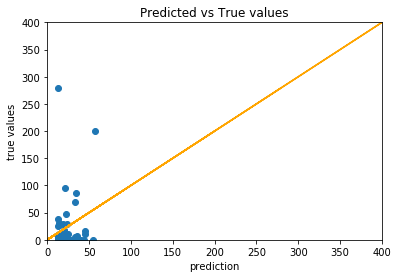

In [83]:
plt.scatter(y_pred, y_test)
plt.plot(y_test, y_test, c = 'orange')
plt.xlabel('prediction')
plt.ylabel('true values')
plt.xlim(0,400)
plt.ylim(0,400)
plt.title('Predicted vs True values')